Importing Necessary Library

In [1]:
# Importing Necessary Libraries
import wandb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import resnet
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Loading the Dataset

In [2]:
config = {
    'path_dir': "/kaggle/input/monkeypox/converted_data"
}
config

{'path_dir': '/kaggle/input/monkeypox/converted_data'}

In [33]:
# initialize Weights & Biases
wandb.login(key="43ba0e8a2e5913526b62f3733783d0f493c6c39a")
wandb.init(project="final-project-new-ablations", name="dnyaboke_project_new_trial2")

print("[INFO] loading images...")
imagePaths = list(paths.list_images(config['path_dir']))
data = []
labels = []

print(f"Number of image paths loaded: {len(imagePaths)}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[INFO] loading images...
Number of image paths loaded: 90


In [34]:
# define paths directly
root_dir = config["path_dir"]
monkeypox_label = "Monkeypox_gray"
monkeypox_path = f"{root_dir}/{monkeypox_label}"
# chickenpox_path = f"config["path_dir"]/chicken_pox"
chickenpox_label = "Chickenpox_grayscale" #"chicken_pox"
chickenpox_path = f"{root_dir}/{chickenpox_label}"

# function to load images from a directory with a specific label
def load_images_from_folder(folder, label):
    images = []
    labels_list = []
    count = 0

    # check if directory exists
    if not os.path.exists(folder):
        print(f"Warning: {folder} directory does not exist")
        return images, labels_list

    # load all images from the directory
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))  # Resize to match VGG16 input
                images.append(image)
                labels_list.append(label)
                count += 1

    print(f"Loaded {count} images from {folder}")
    return images, labels_list

# load Chickenpox images
chickenpox_images, chickenpox_labels = load_images_from_folder(chickenpox_path, chickenpox_label)

# load Monkeypox images
monkeypox_images, monkeypox_labels = load_images_from_folder(monkeypox_path, monkeypox_label)

# combine the data
data = chickenpox_images + monkeypox_images
labels = chickenpox_labels + monkeypox_labels

# convert to numpy arrays
data = np.array(data, dtype="float32") / 255.0  # Normalize pixel values
labels = np.array(labels)

print(f"Final dataset size: {len(data)} images")
print(f"Unique labels: {np.unique(labels)}")
print(f"Label counts: {[(label, (labels == label).sum()) for label in np.unique(labels)]}")

Loaded 47 images from /kaggle/input/monkeypox/converted_data/Chickenpox_grayscale
Loaded 43 images from /kaggle/input/monkeypox/converted_data/Monkeypox_gray
Final dataset size: 90 images
Unique labels: ['Chickenpox_grayscale' 'Monkeypox_gray']
Label counts: [('Chickenpox_grayscale', 47), ('Monkeypox_gray', 43)]


Image preprocessing and extract the Label

In [35]:
import numpy as np
import random

# create dictionaries to store data by class
class_data = {monkeypox_label: [], chickenpox_label: []}
for img, lbl in zip(data, labels):
    class_data[lbl].append(img)

# Optionally, shuffle the images for each class
for key in class_data:
    random.shuffle(class_data[key])

# create train and test sets with specific counts
trainX = []
testX = []
trainY = []
testY = []

# monkeypox: 34 train, 9 test
monkey_images = class_data[monkeypox_label]
if len(monkey_images) >= 43:
    monkey_train = monkey_images[:34]
    monkey_test = monkey_images[34:43]
    trainX.extend(monkey_train)
    testX.extend(monkey_test)
    trainY.extend([monkeypox_label] * len(monkey_train))
    testY.extend([monkeypox_label] * len(monkey_test))
else:
    print(f"Warning: Not enough Monkeypox images. Found {len(monkey_images)}, need 43")

# chickenpox: 38 train, 9 test
chicken_images = class_data[chickenpox_label]
if len(chicken_images) >= 47:
    chicken_train = chicken_images[:38]
    chicken_test = chicken_images[38:47]
    trainX.extend(chicken_train)
    testX.extend(chicken_test)
    trainY.extend([chickenpox_label] * len(chicken_train))
    testY.extend([chickenpox_label] * len(chicken_test))
else:
    print(f"Warning: Not enough Chickenpox images. Found {len(chicken_images)}, need 47")

# convert to numpy arrays
trainX = np.array(trainX, dtype="float32")
testX = np.array(testX, dtype="float32")
trainY = np.array(trainY)
testY = np.array(testY)

print(f"Train data shape: {trainX.shape}, Train labels shape: {trainY.shape}")
print(f"Test data shape: {testX.shape}, Test labels shape: {testY.shape}")


Train data shape: (72, 224, 224, 3), Train labels shape: (72,)
Test data shape: (18, 224, 224, 3), Test labels shape: (18,)


In [5]:
# # create dictionaries to store data by class
# class_data = {monkeypox_label: [], chickenpox_label: []}
# for img, lbl in zip(data, labels):
#     class_data[lbl].append(img)

# # create train and test sets with specific counts
# trainX = []
# testX = []
# trainY = []
# testY = []

# # monkeypox: 34 train, 9 test
# monkey_images = class_data[monkeypox_label]
# if len(monkey_images) >= 43:
#     monkey_train = monkey_images[:34]
#     monkey_test = monkey_images[34:43]
#     trainX.extend(monkey_train)
#     testX.extend(monkey_test)
#     trainY.extend([monkeypox_label] * len(monkey_train))
#     testY.extend([monkeypox_label] * len(monkey_test))
# else:
#     print(f"Warning: Not enough Monkeypox images. Found {len(monkey_images)}, need 43")

# # chickenpox: 38 train, 9 test
# chicken_images = class_data[chickenpox_label]
# if len(chicken_images) >= 47:
#     chicken_train = chicken_images[:38]
#     chicken_test = chicken_images[38:47]
#     trainX.extend(chicken_train)
#     testX.extend(chicken_test)
#     trainY.extend([chickenpox_label] * len(chicken_train))
#     testY.extend([chickenpox_label] * len(chicken_test))
# else:
#     print(f"Warning: Not enough Chickenpox images. Found {len(chicken_images)}, need 47")

# # convert to numpy arrays
# trainX = np.array(trainX, dtype="float32")
# testX = np.array(testX, dtype="float32")
# trainY = np.array(trainY)
# testY = np.array(testY)

# print(f"Train data shape: {trainX.shape}, Train labels shape: {trainY.shape}")
# print(f"Test data shape: {testX.shape}, Test labels shape: {testY.shape}")

Train data shape: (72, 224, 224, 3), Train labels shape: (72,)
Test data shape: (18, 224, 224, 3), Test labels shape: (18,)


In [36]:
# convert labels to categorical
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [ ]:
# # Initialize the training data augmentation object
# trainAug = ImageDataGenerator(
#     rotation_range=45, 
#     width_shift_range=0.02, 
#     height_shift_range=0.02, 
#     zoom_range=0.02, 
#     horizontal_flip=True, 
#     fill_mode="nearest"
# )

In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model

# # 1) Load pre-trained VGG16 (convolution + maxpool only; no Dense "top")
# baseModel = VGG16(weights="imagenet", include_top=False,
#                   input_tensor=Input(shape=(224, 224, 3)))

# # 2) Build your "modified" classification head:
# headModel = baseModel.output

# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(512, activation="relu")(headModel)   # 1st Dense
# headModel = Dropout(0.5)(headModel)                    # Dropout
# headModel = Dense(256, activation="relu")(headModel)   # 2nd Dense
# headModel = Dense(128, activation="relu")(headModel)   # 3rd Dense
# headModel = Dense(2, activation="softmax")(headModel)  # Final classification

# # 3) Combine base + new head
# model = Model(inputs=baseModel.input, outputs=headModel)

# # 4) Freeze the base model layers for initial training
# for layer in baseModel.layers:
#     layer.trainable = False

# # # 5) Compile
# # model.compile(optimizer="adam", loss="categorical_crossentropy", 
# #               metrics=["accuracy"])


In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1) load pre-trained VGG16 (convolution + maxpool layers only; no Dense "top")
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# 2) freeze the base model layers for initial training
for layer in baseModel.layers:
    layer.trainable = False

# 3) build the modified classification head
x = baseModel.output
# use GlobalAveragePooling2D to reduce the feature maps to a vector,
# which can help reduce overfitting compared to a full Flatten
x = GlobalAveragePooling2D(name="avg_pool")(x)
# first Dense layer (512 neurons) with ReLU activation
x = Dense(512, activation="relu")(x)
# batch normalization can help stabilize and speed up training
x = BatchNormalization()(x)
# dropout layer to help prevent overfitting (rate of 0.5 as in the paper)
x = Dropout(0.5)(x)
# second Dense layer (256 neurons)
x = Dense(256, activation="relu")(x)
# third Dense layer (128 neurons)
x = Dense(128, activation="relu")(x)
# final Dense layer for binary classification (2 neurons, softmax activation)
predictions = Dense(2, activation="softmax")(x)

# 4) combine the base model and the new head
model = Model(inputs=baseModel.input, outputs=predictions)

# 5) compile the model with Adam optimizer and categorical crossentropy
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
# model.summary()

In [38]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 30

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
import tensorflow as tf
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# #opt = tf.keras.optimizers.SGD(learning_rate=INIT_LR)
# opt = tf.keras.optimizers.RMSprop(learning_rate=INIT_LR)



# opt = Adam(learning_rate=INIT_LR) 

In [ ]:
# # Compile the model
# print("[INFO] compiling model...")
# # model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# model.compile(optimizer="adam", loss="categorical_crossentropy", 
#               metrics=["accuracy"])

# # # Start timing
# # t1 = time.process_time()

# # Train the model
# print("[INFO] training head...")
# wandb_callback = wandb.keras.WandbMetricsLogger(log_freq="epoch")
# import time
# t1=time.process_time()
# H = model.fit(
#     x=trainX, 
#     y=trainY, 
#     batch_size=BS,
#     steps_per_epoch=len(trainX) // BS,
#     validation_data=(testX, testY),
#     validation_steps=len(testX) // BS,
#     epochs=EPOCHS,
#      callbacks=[wandb_callback]
# )

# # End timing
# t2 = time.process_time()
# print("Process time:", t2 - t1)

In [41]:
# -----------------------------------------
# Initial Training Phase (Head Training)
# -----------------------------------------
print("[INFO] compiling model for head training...")
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print("[INFO] training head...")
wandb_callback = wandb.keras.WandbMetricsLogger(log_freq="epoch")
import time
t1 = time.process_time()
H = model.fit(
    x=trainX, 
    y=trainY, 
    batch_size=BS,
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[wandb_callback]
)
t2 = time.process_time()
print("Process time:", t2 - t1)

# -----------------------------------------
# Fine-Tuning Phase (Unfreezing some base layers)
# -----------------------------------------
# Unfreeze the last few layers of the base model for fine-tuning.
# (Adjust the number of layers as needed based on your experiment)
for layer in baseModel.layers[-4:]:
    layer.trainable = True

[INFO] compiling model for head training...
[INFO] training head...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5333 - loss: 1.0060 - val_accuracy: 0.6667 - val_loss: 0.6793
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5833 - loss: 0.8878 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7556 - loss: 0.4870 - val_accuracy: 0.5000 - val_loss: 0.7233
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4167 - loss: 1.1756 - val_accuracy: 0.5000 - val_loss: 0.7207
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7000 - loss: 0.4976 - val_accuracy: 0.5000 - val_loss: 0.7021
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9167 - loss: 0.3848 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8778 - loss: 0.3200 - val_accuracy: 0.5000 - val_loss: 0.6896
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

In [42]:
FINE_TUNE_EPOCHS = 20 

# Re-compile the model with a lower learning rate for fine-tuning
print("[INFO] compiling model for fine-tuning...")
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Continue training (fine-tuning) the model.
print("[INFO] fine-tuning model...")
t1 = time.process_time()
H_finetune = model.fit(
    x=trainX, 
    y=trainY, 
    batch_size=BS,
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=FINE_TUNE_EPOCHS,  # Set the number of fine-tuning epochs as needed
    callbacks=[wandb_callback]
)
t2 = time.process_time()
print("Fine-tuning process time:", t2 - t1)


[INFO] compiling model for fine-tuning...
[INFO] fine-tuning model...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 997ms/step - accuracy: 0.9889 - loss: 0.0385 - val_accuracy: 0.7222 - val_loss: 0.7027
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 1.0000 - loss: 0.0594 - val_accuracy: 0.7222 - val_loss: 0.7120
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9889 - loss: 0.0348 - val_accuracy: 0.7222 - val_loss: 0.7204
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9167 - loss: 0.0853 - val_accuracy: 0.7222 - val_loss: 0.7222
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9889 - loss: 0.0319 - val_accuracy: 0.7222 - val_loss: 0.7279
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0243 - val_accuracy: 0.7222 - val_loss: 0.7333
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9778 - loss: 0.0778 - val_accuracy: 0.7222 - val_loss: 0.7498
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - 

In [43]:
print(len(H.history['loss']))

100


In [44]:
model.save_weights("my_model_weights.weights.h5")

In [18]:
# Log model weights to W&B as an artifact
artifact = wandb.Artifact("monkeypox-model", type="model")
artifact.add_file("my_model_weights.weights.h6")
wandb.log_artifact(artifact)

#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
                      precision    recall  f1-score   support

Chickenpox_grayscale       1.00      0.53      0.69        38
      Monkeypox_gray       0.65      1.00      0.79        34

            accuracy                           0.75        72
           macro avg       0.83      0.76      0.74        72
        weighted avg       0.84      0.75      0.74        72



In [45]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# Log metrics to W&B
wandb.log({
    "train_accuracy": acc,
    "train_sensitivity": sensitivity,
    "train_specificity": specificity
})

[[20 18]
 [ 0 34]]
acc: 0.7500
sensitivity: 0.5263
specificity: 1.0000


In [46]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
testpredict = np.argmax(predIdys, axis=1)
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

[INFO] evaluating network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
                      precision    recall  f1-score   support

Chickenpox_grayscale       0.70      0.78      0.74         9
      Monkeypox_gray       0.75      0.67      0.71         9

            accuracy                           0.72        18
           macro avg       0.72      0.72      0.72        18
        weighted avg       0.73      0.72      0.72        18



In [47]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# Log test metrics to W&B
wandb.log({
    "test_accuracy": acc,
    "test_sensitivity": sensitivity,
    "test_specificity": specificity
})

[[7 2]
 [3 6]]
acc: 0.7222
sensitivity: 0.7778
specificity: 0.6667


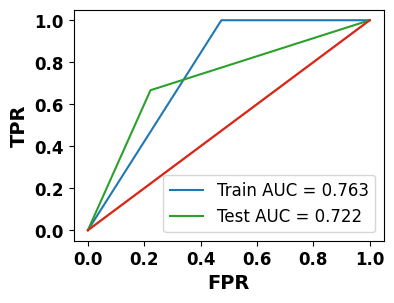

<Figure size 640x480 with 0 Axes>

In [48]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
fig = plt.figure(figsize = (4, 3))
fpr1,tpr1,_=roc_curve(np.argmax(trainY, axis=1),np.argmax(predIdxs, axis=1))
fpr2,tpr2,_=roc_curve(np.argmax(testY, axis=1),np.argmax(predIdys, axis=1))
area_under_curve1=auc(fpr1,tpr1)
random_probs=[0 for i in range(len(trainY.ravel()))]
p_fpr1,p_tpr1,threshold=roc_curve(trainY.ravel(),random_probs, pos_label=1)
plt.plot(fpr1,tpr1, label='Train AUC = {:.3f}'.format(area_under_curve1))
plt.plot(p_fpr1, p_tpr1)
area_under_curve2=auc(fpr2,tpr2)
random_probs2=[0 for i in range(len(testY.ravel()))]
p_fpr2,p_tpr2,threshold=roc_curve(testY.ravel(),random_probs2, pos_label=1)
plt.plot(fpr2,tpr2, label='Test AUC = {:.3f}'.format(area_under_curve2))
plt.plot(p_fpr2, p_tpr2)

    # x label
plt.xlabel('FPR',fontsize=14, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('TPR', fontsize=14, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
plt.legend()
plt.legend(prop={'size':12})
plt.savefig('ROC',dpi=200, bbox_inches='tight')
plt.show();

# Log ROC curve to W&B
wandb.log({"ROC_curve": wandb.Image(plt)})

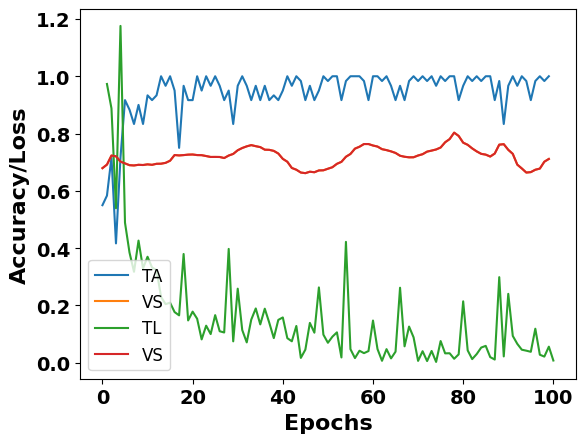

<Figure size 640x480 with 0 Axes>

In [49]:
from matplotlib.ticker import FormatStrFormatter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(np.arange(0, len(val_loss)), val_loss, label='VS')

plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VS')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'size':12})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('ACC',dpi=200, bbox_inches='tight')
plt.show()

wandb.init()

# Log accuracy/loss plot to W&B
wandb.log({"Accuracy_Loss_Plot": wandb.Image(plt)})


In [50]:
# Finish W&B run
wandb.finish()

epoch/accuracy,▁▅▆▇█▆▇▇█▇▇▆▇█▇███████▇█▆██▆▄███████████
epoch/epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇██▁▁▁▁▂▂▂▂▂
epoch/learning_rate,███████████████████████████████████▁▁▁▁▁
epoch/loss,█▅▃▄▂▂▂▂▄▂▂▂▂▁▁▂▃▁▂▁▁▁▁▁▁▁▃▁▁▁▂▁▁▂▁▁▂▁▁▁
epoch/val_accuracy,▄▅▄▄▄▃▇▆▂▂▁▁▁▇▇▇▇▆▆▆███▅▆▆▆▆▇▇█▇████████
epoch/val_loss,▂▅▃▃▃▅▄▄▄▆▃▂▁▁▂▃▃▆▇▇▆▅▄▄▅▆▇▇▅▇▃▁▂▄▃▄▅▇▇█
test_accuracy,▁
test_sensitivity,▁
test_specificity,▁
train_accuracy,▁
train_sensitivity,▁
